# Thứ tự các bước

- Khám phá dữ liệu ban đầu: kiểm tra thiếu dữ liệu, ngoại lai, xu hướng và mùa vụ.
- Kiểm tra tính dừng, xử lý vi phân nếu cần.
- Chọn mô hình ARIMA/SARIMA với tham số tối ưu.
- Huấn luyện mô hình.
- Chẩn đoán phần dư (ACF, PACF, phân phối chuẩn, kiểm định tự tương quan).
- Dự báo và đánh giá kết quả (RMSE, MAE, AIC, BIC).
- Dự báo tương lai.

In [1]:
# !pip install pmdarima

In [1]:
# 1. Import thư viện cần thiết
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima  # Auto ARIMA
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# 2. Load và tiền xử lý dữ liệu
df = pd.read_csv("../data/data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

# Chỉ quan tâm cột 'Adj Close'
df = df[['Adj Close']].asfreq('D')
print('Before interpolate:', df['Adj Close'].count())
df['Adj Close'] = df['Adj Close'].interpolate(method='linear')
print('After interpolate:', df['Adj Close'].count())

Before interpolate: 16229
After interpolate: 23686


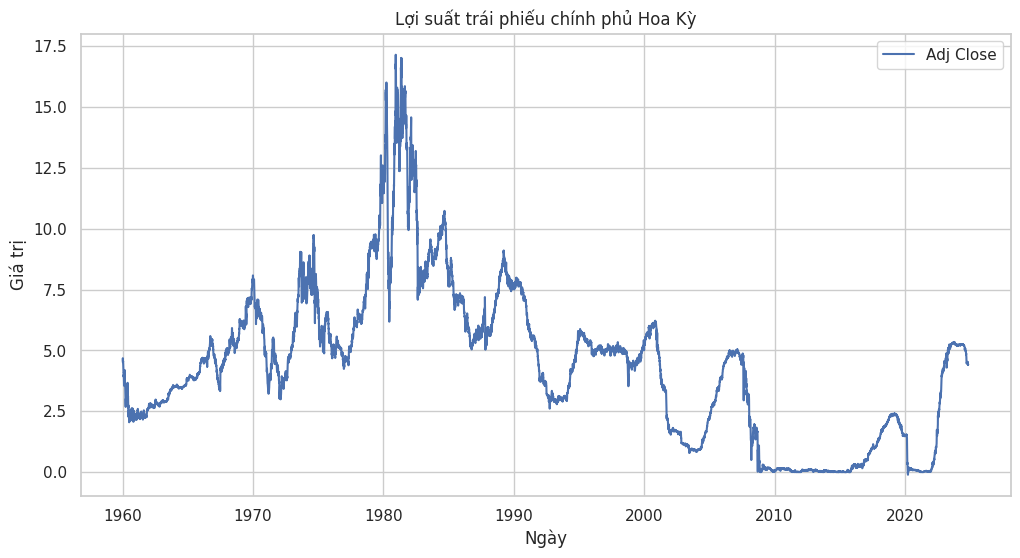

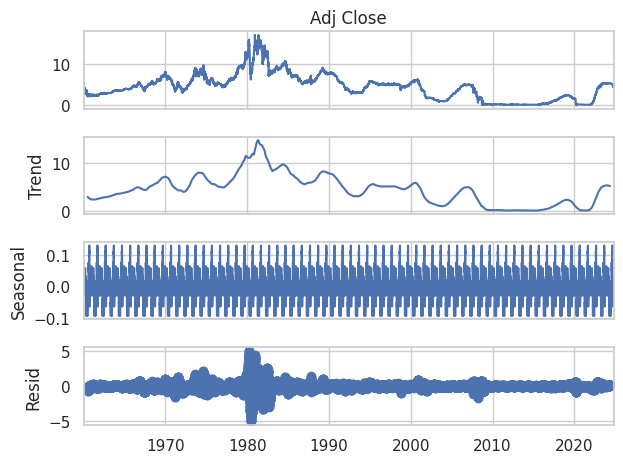

ADF Statistic: -2.4054269701729716
P-value: 0.14021054154624973
Chuỗi không dừng, cần vi phân.


In [4]:
# 3. Khám phá dữ liệu ban đầu
# Vẽ dữ liệu
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close')
plt.title('Lợi suất trái phiếu chính phủ Hoa Kỳ')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.legend()
plt.show()

# Phân tích thành phần xu hướng và mùa vụ
# 1961-01-03
# 251
# 1961-12-29
# 499
# => 248. Trung bình một năm có 252 ngày giao dịch.

# Sau khi noi suy thanh la 365 ngay 1 nam
decompose_result = seasonal_decompose(df['Adj Close'], model='additive', period=365)
decompose_result.plot()
plt.show()

# Kiểm tra tính dừng
result = adfuller(df['Adj Close'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")
if result[1] > 0.05:
    print("Chuỗi không dừng, cần vi phân.")
else:
    print("Chuỗi dừng.")

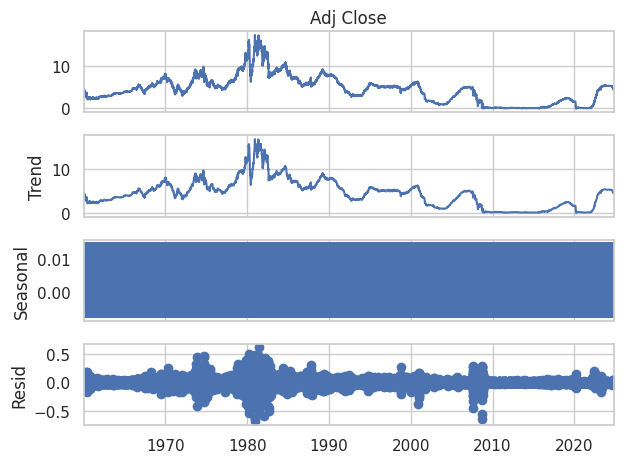

In [5]:
decompose_result = seasonal_decompose(df['Adj Close'], model='additive', period=7)
decompose_result.plot()
plt.show()

In [3]:
# 4. Chọn mô hình tối ưu với auto_arima

from statsmodels.tsa.arima.model import ARIMA

# Tạo mô hình ARIMA (2, 1, 2)
arima_model = ARIMA(df['Adj Close'], order=(2, 1, 2))
arima_fit = arima_model.fit()

# In ra tóm tắt của mô hình ARIMA
print(arima_fit.summary())

# Giới hạn phạm vi các tham số
# model_auto = auto_arima(
#     df['Adj Close'],
#     # start_p=2, max_p=3,        # Giới hạn p từ 2 đến 2
#     # start_q=2, max_q=3,        # Giới hạn q từ 2 đến 2
#     # d=1,                       # Tự động xác định bậc sai phân
#     # start_P=2, max_P=3,        # Giới hạn P từ 1 đến 2
#     # start_Q=2, max_Q=3,        # Giới hạn Q từ 1 đến 2
#     # D=1,                       # Tự động xác định bậc sai phân theo mùa
#     # seasonal=True, m=365,      # Hàng năm
#     stepwise=False,             # Sử dụng phương pháp từng bước
#     p=2, d=1, q=2,              # Tham số ARIMA
#     P=2, D=1, Q=2,              # Tham số SARIMA
#     seasonal=True, m=7,         # Hàng tuần cho nhanh
#     suppress_warnings=True,     # Bỏ qua các cảnh báo không cần thiết
#     error_action="ignore",      # Bỏ qua lỗi
#     trace=True                  # In ra thông tin quá trình
# )

# # In ra kết quả của mô hình tối ưu
# print(model_auto.summary())

#  ARIMA(0,1,0)(0,1,0)[7]             : AIC=-48836.102, Time=0.59 sec
#  ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=2.96 sec
#  ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=13.18 sec
#  ARIMA(0,1,0)(1,1,0)[7]             : AIC=-55716.532, Time=2.46 sec
#  ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=5.98 sec
#  ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=21.82 sec
#  ARIMA(0,1,0)(2,1,0)[7]             : AIC=-58122.285, Time=7.87 sec
#  ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=28.27 sec
#  ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=42.14 sec
#  ARIMA(0,1,1)(0,1,0)[7]             : AIC=-49839.453, Time=1.07 sec
#  ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=8.72 sec
#  ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=24.62 sec
#  ARIMA(0,1,1)(1,1,0)[7]             : AIC=-56754.168, Time=4.66 sec
#  ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=14.62 sec

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                23686
Model:                 ARIMA(2, 1, 2)   Log Likelihood               32370.993
Date:                Fri, 22 Nov 2024   AIC                         -64731.986
Time:                        10:18:44   BIC                         -64691.623
Sample:                    01-04-1960   HQIC                        -64718.888
                         - 11-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1146      0.376      0.305      0.760      -0.622       0.851
ar.L2          0.0824      0.149      0.555      0.579      -0.209       0.374
ma.L1          0.0915      0.376      0.243      0.8

In [9]:
# # Cố định tham số ARIMA và SARIMA
# model_auto = auto_arima(
#     df['Adj Close'],
#     order=(2, 1, 2),                # Tham số cho ARIMA
#     seasonal_order=(2, 1, 2, 7),    # Tham số cho SARIMA
#     suppress_warnings=True,          # Bỏ qua các cảnh báo không cần thiết
#     error_action="ignore",           # Bỏ qua lỗi
#     trace=True                       # In ra thông tin quá trình
# )

# # In ra kết quả của mô hình tối ưu
# print(model_auto.summary())

# Performing stepwise search to minimize aic
#  ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-64729.986, Time=16.19 sec
#  ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-63572.806, Time=3.25 sec
#  ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64693.870, Time=1.39 sec
#  ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-64569.930, Time=3.57 sec
#  ARIMA(0,1,0)(0,0,0)[0]             : AIC=-63574.806, Time=0.54 sec
#  ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-64732.664, Time=7.10 sec
#  ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-64712.755, Time=5.30 sec
#  ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-64732.578, Time=7.37 sec
#  ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-64726.926, Time=8.46 sec
#  ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-64736.586, Time=8.35 sec
#  ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-64735.907, Time=8.13 sec
#  ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-64733.882, Time=14.39 sec
#  ARIMA(0,1,3)(0,0,0)[0]             : AIC=-64738.586, Time=1.45 sec
#  ARIMA(0,1,2)(0,0,0)[0]             : AIC=-64714.762, Time=0.94 sec
#  ARIMA(1,1,3)(0,0,0)[0]             : AIC=-64728.936, Time=2.15 sec
#  ARIMA(0,1,4)(0,0,0)[0]             : AIC=-64737.928, Time=2.66 sec
#  ARIMA(1,1,2)(0,0,0)[0]             : AIC=-64734.664, Time=1.02 sec
#  ARIMA(1,1,4)(0,0,0)[0]             : AIC=-64741.112, Time=6.62 sec
#  ARIMA(2,1,4)(0,0,0)[0]             : AIC=-65047.087, Time=12.20 sec
#  ARIMA(2,1,3)(0,0,0)[0]             : AIC=-64795.732, Time=7.59 sec
#  ARIMA(3,1,4)(0,0,0)[0]             : AIC=-64862.894, Time=13.52 sec
#  ARIMA(2,1,5)(0,0,0)[0]             : AIC=-64876.616, Time=12.76 sec
#  ARIMA(1,1,5)(0,0,0)[0]             : AIC=-64768.759, Time=4.69 sec
#  ARIMA(3,1,3)(0,0,0)[0]             : AIC=-64752.745, Time=7.97 sec
#  ARIMA(3,1,5)(0,0,0)[0]             : AIC=-64935.671, Time=14.47 sec

In [14]:
# 5. Phân chia dữ liệu (60-20-20)
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

In [ ]:
# 6. Huấn luyện mô hình với tham số tối ưu
# order = model_auto.order
# seasonal_order = model_auto.seasonal_order
# model = ARIMA(train_data['Adj Close'], order=order, seasonal_order=seasonal_order)
# model_fit = model.fit()

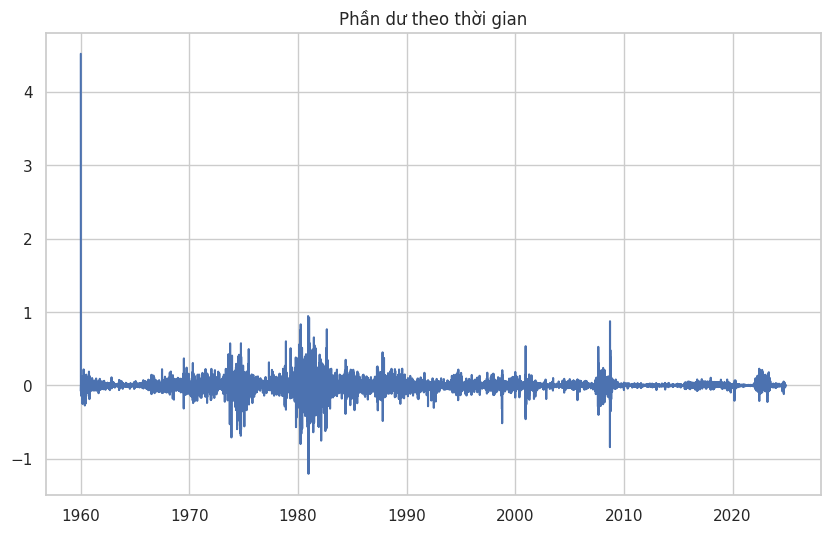

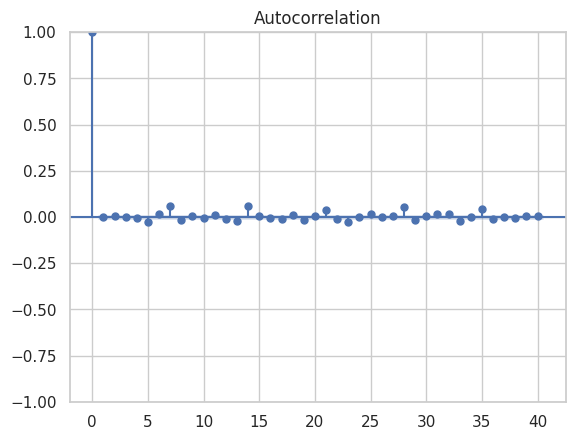

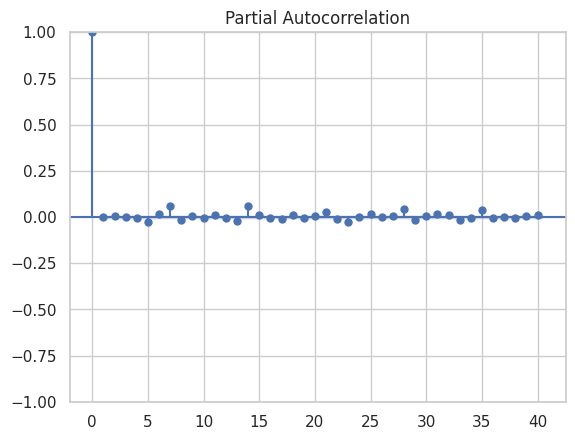

In [4]:
# 7. Chẩn đoán phần dư
# residuals = model_fit.resid
residuals = arima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Phần dư theo thời gian')
plt.savefig('arima212_residuals.png')
plt.show()

plot_acf(residuals, lags=40)
plt.savefig('arima212_acf_residuals.png')
plt.show()
plot_pacf(residuals, lags=40)
plt.savefig('arima212_pacf_residuals.png')
plt.show()

In [27]:
# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")

Giá trị thống kê Shapiro-Wilk: 0.5399980143866582
P-value: 1.2046475875576489e-118
Phần dư không có phân phối chuẩn (bác bỏ H0)


MSE: 9.955084599442042, RMSE: 3.155167919373237


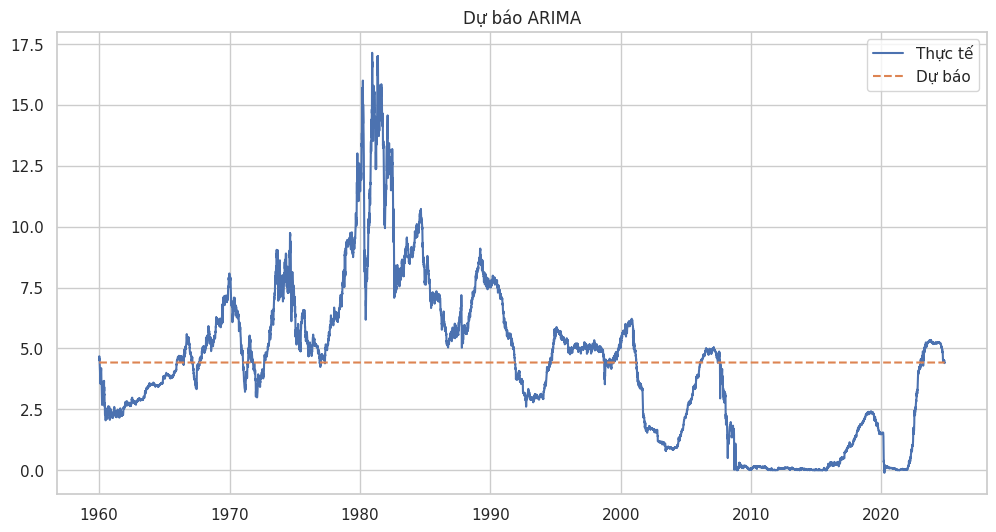

In [5]:
# 8. Dự báo và đánh giá
# arima(2, 1, 2)
forecast = arima_fit.forecast(steps=len(df))
mse = mean_squared_error(df['Adj Close'], forecast)
print(f"MSE: {mse}, RMSE: {sqrt(mse)}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'], label='Thực tế')
plt.plot(df.index, forecast, label='Dự báo', linestyle='--')
plt.legend()
plt.title('Dự báo ARIMA')
plt.savefig('arima212_forecast.png')
plt.show()

In [21]:
set(forecast), min(forecast), max(forecast), len(set(forecast))

({4.423208548187216,
  4.423376299826944,
  4.423412723352657,
  4.423430720015024,
  4.423435783969696,
  4.423437847234033,
  4.423438500974817,
  4.423438745909716,
  4.423438827849582,
  4.42343885742303,
  4.423438867564222,
  4.423438871163323,
  4.423438872411441,
  4.42343887285105,
  4.423438873004278,
  4.423438873058062,
  4.423438873076853,
  4.4234388730834375,
  4.423438873085741,
  4.423438873086547,
  4.4234388730868295,
  4.423438873086928,
  4.423438873086963,
  4.423438873086975,
  4.42343887308698,
  4.423438873086981,
  4.423438873086982},
 4.423208548187216,
 4.423438873086982,
 27)

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Tạo mô hình SARIMA (2, 1, 2)(2, 1, 2)[7]
sarima_model = SARIMAX(df['Adj Close'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 7))
sarima_fit = sarima_model.fit()

# In ra tóm tắt của mô hình SARIMA
print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26338D+00    |proj g|=  4.89072D+00


 This problem is unconstrained.



At iterate    5    f= -1.33225D+00    |proj g|=  2.02663D+00

At iterate   10    f= -1.35305D+00    |proj g|=  4.95226D-02

At iterate   15    f= -1.35528D+00    |proj g|=  1.08585D+00

At iterate   20    f= -1.36169D+00    |proj g|=  6.20440D-01

At iterate   25    f= -1.37139D+00    |proj g|=  2.23509D-01

At iterate   30    f= -1.37743D+00    |proj g|=  1.63354D-01

At iterate   35    f= -1.37844D+00    |proj g|=  7.70113D-02

At iterate   40    f= -1.37851D+00    |proj g|=  1.03630D-02

At iterate   45    f= -1.37853D+00    |proj g|=  3.84495D-04


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.37853D+00    |proj g|=  7.47096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   7.471D-03  -1.379D+00
  F =  -1.3785276662804231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                     
Dep. Variable:                         Adj Close   No. Observations:                23686
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               32651.806
Date:                           Fri, 22 Nov 2024   AIC                         -65285.613
T

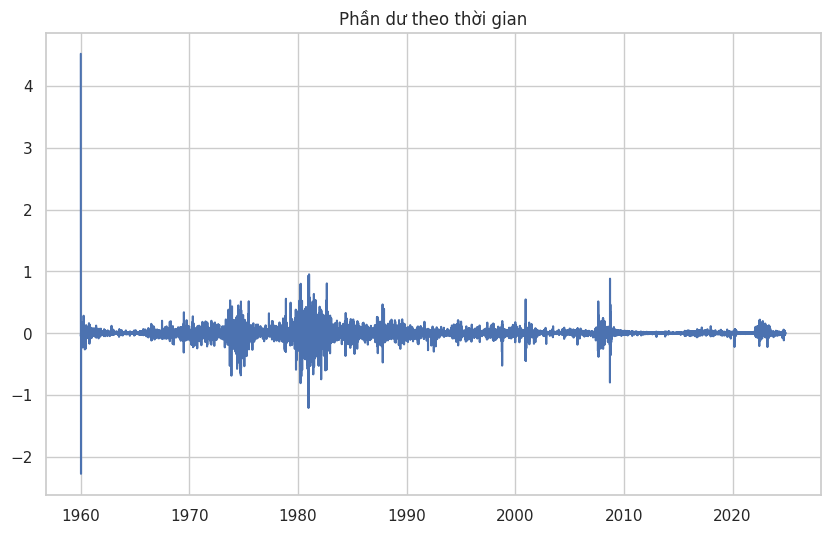

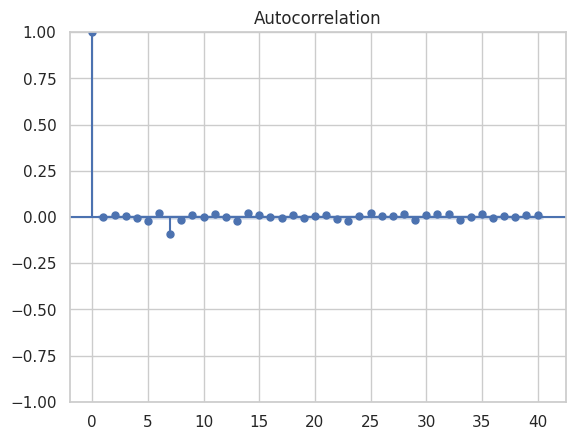

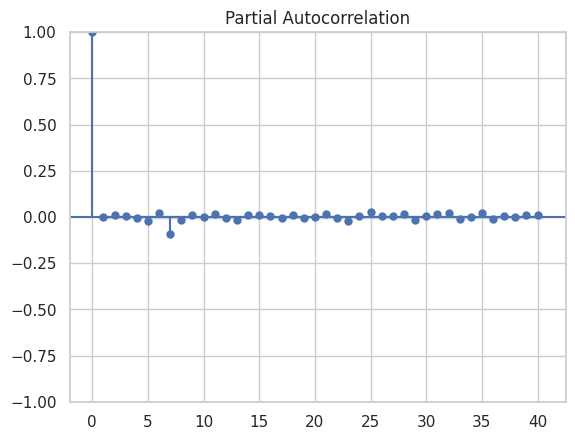

In [22]:
sarima_residuals = sarima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(sarima_residuals)
plt.title('Phần dư theo thời gian')
plt.show()

plot_acf(sarima_residuals, lags=40)
plt.show()
plot_pacf(sarima_residuals, lags=40)
plt.show()

In [26]:
# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
from scipy.stats import shapiro

stat, p_value = shapiro(sarima_residuals)
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")

Giá trị thống kê Shapiro-Wilk: 0.5180870115585684
P-value: 6.270306793687593e-120
Phần dư không có phân phối chuẩn (bác bỏ H0)


MSE: 51.415886036296044, RMSE: 7.170487154740328


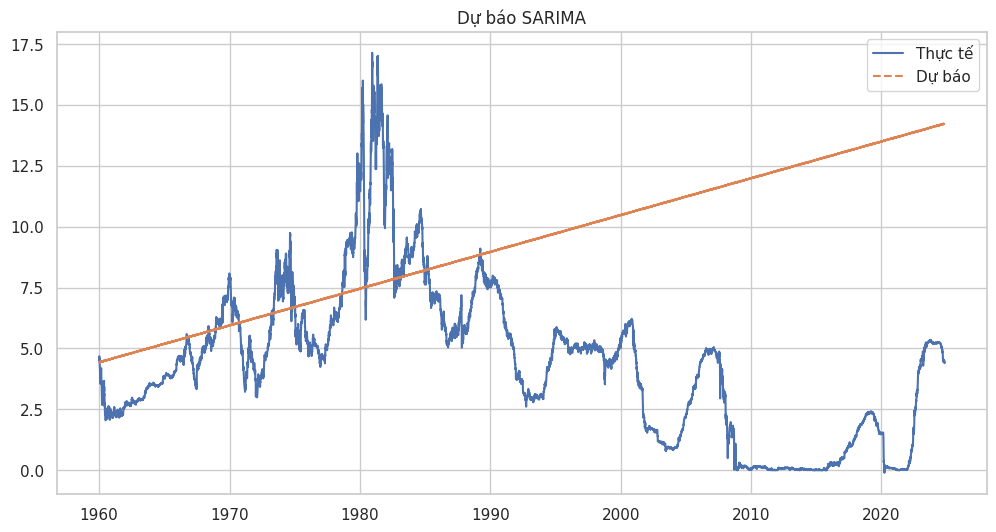

In [25]:
sarima_forecast = sarima_fit.forecast(steps=len(df))
mse = mean_squared_error(df['Adj Close'], sarima_forecast)
print(f"MSE: {mse}, RMSE: {sqrt(mse)}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'], label='Thực tế')
plt.plot(df.index, sarima_forecast, label='Dự báo', linestyle='--')
plt.legend()
plt.title('Dự báo SARIMA')
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15985D+00    |proj g|=  4.40991D+00


 This problem is unconstrained.



At iterate    5    f= -1.24997D+00    |proj g|=  6.21958D-02

At iterate   10    f= -1.26734D+00    |proj g|=  1.89438D-01

At iterate   15    f= -1.27604D+00    |proj g|=  2.71816D-02

At iterate   20    f= -1.27630D+00    |proj g|=  3.40759D-03

At iterate   25    f= -1.27635D+00    |proj g|=  7.32768D-04

At iterate   30    f= -1.27635D+00    |proj g|=  2.19159D-03

At iterate   35    f= -1.27636D+00    |proj g|=  5.10462D-02

At iterate   40    f= -1.27657D+00    |proj g|=  6.96076D-02

At iterate   45    f= -1.27670D+00    |proj g|=  8.51417D-02

At iterate   50    f= -1.27676D+00    |proj g|=  2.49779D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 21.177175874077456, RMSE: 4.601866564132152


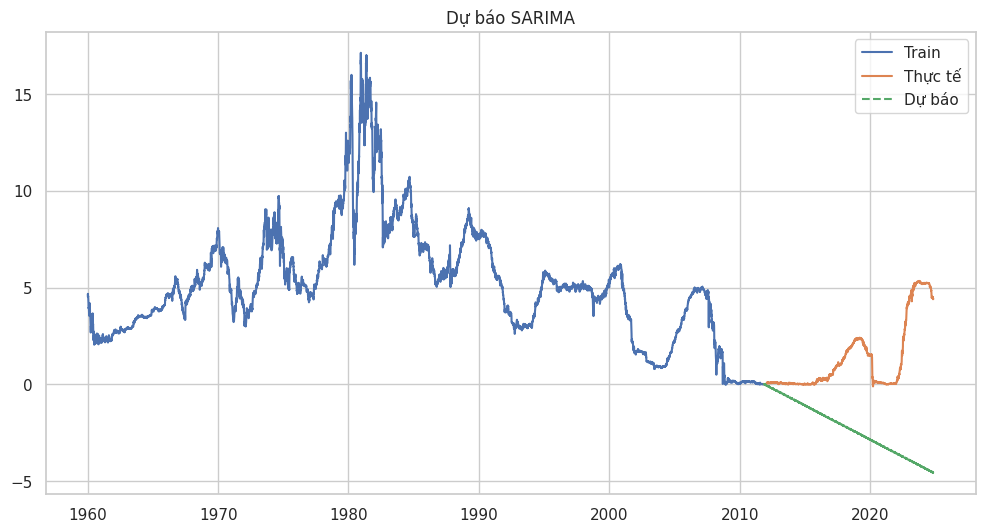

In [4]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Chia dữ liệu thành train và test
train_size = int(len(df) * 0.8)
train, test = df['Adj Close'][:train_size], df['Adj Close'][train_size:]

# Huấn luyện mô hình trên tập train
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(2, 1, 2, 7))
sarima_fit = model.fit()

# Dự báo trên tập test
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Tính toán lỗi
mse = mean_squared_error(test, sarima_forecast)
print(f"MSE: {mse}, RMSE: {sqrt(mse)}")

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Thực tế')
plt.plot(test.index, sarima_forecast, label='Dự báo', linestyle='--')
plt.legend()
plt.title('Dự báo SARIMA')
plt.show()
